In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np

import scqubits as scq
import qutip as qt

from qutip.ipynbtools import HTMLProgressBar

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [3]:
# Map bare states of each transmon to dressed states in combined system
def find_level(H, ket_orig_basis):
    evals, evecs = H.eigenstates()
    best_overlap = 0
    best_state = -1
    for n, evec in enumerate(evecs):
        overlap = np.abs(ket_orig_basis.overlap(evec))
        if overlap > best_overlap:
            best_overlap = overlap
            best_state = n
    return best_state, evecs[best_state]

In [4]:
transmon1_consts = dict(
    EC=0.25 * GHz,
    EJ=21.0 * GHz,
)

transmon2_consts = dict(
    EC=0.3 * GHz,
    EJ=20.0 * GHz,
)

transmon1 = scq.Transmon(
    **transmon1_consts,
    ng=0,
    ncut = 110,
    truncated_dim = 5
)

transmon2 = scq.Transmon(
    **transmon2_consts,
    ng=0,
    ncut = 110,
    truncated_dim = 5
)

q1_isCavity = False
q2_isCavity = False


In [5]:
evals_count = 5
cutoff = evals_count

evals1, evecs1 = transmon1.eigensys(evals_count=evals_count)
evals1 = evals1 - evals1[0] 

evals2, evecs2 = transmon2.eigensys(evals_count=evals_count)
evals2 = evals2 - evals2[0]

alpha1 = alpha2 = 0
if not q1_isCavity: alpha1 = evals1[2]-2*evals1[1]
if not q2_isCavity: alpha2 = evals2[2]-2*evals2[1]

print(evals1[1], evals2[1], alpha1, alpha2)

6.219955176682575 6.613448853505485 -0.27656660001468936 -0.3368931055765696


In [11]:
# eg <-> gf: g=0.2, eps=0.05
# g = 0.065 # GHz
# eps = 0.01 # GHz # drive amplitude
g = 0.2
eps = 0.05

# wd = 2*evals1[1] + alpha1 - evals2[1]
# wd = evals1[1]

a = qt.tensor(qt.destroy(cutoff), qt.qeye(cutoff)) # transmon1
b = qt.tensor(qt.qeye(cutoff), qt.destroy(cutoff)) # transmon2
H_transmon1 = 2*np.pi*(evals1[1]*a.dag()*a + 1/2*alpha1*a.dag()*a.dag()*a*a)
H_transmon2 = 2*np.pi*(evals2[1]*b.dag()*b + 1/2*alpha2*b.dag()*b.dag()*b*b) # can't have 2 transmons be exactly the same, or else no way to distinguish ge and eg
H_int = 2*np.pi* g * (a + a.dag()) * (b + b.dag())

H = H_transmon1 + H_transmon2 + H_int

levels = dict(
    gg = find_level(H, qt.tensor(qt.basis(cutoff, 0), qt.basis(cutoff, 0)))[1],
    ee = find_level(H, qt.tensor(qt.basis(cutoff, 1), qt.basis(cutoff, 1)))[1],
    eg = find_level(H, qt.tensor(qt.basis(cutoff, 1), qt.basis(cutoff, 0)))[1],
    ge = find_level(H, qt.tensor(qt.basis(cutoff, 0), qt.basis(cutoff, 1)))[1],
    fg = find_level(H, qt.tensor(qt.basis(cutoff, 2), qt.basis(cutoff, 0)))[1],
    gf = find_level(H, qt.tensor(qt.basis(cutoff, 0), qt.basis(cutoff, 2)))[1],
)

# drive at wd = w1 - w2

# wd = np.abs(qt.expect(H, levels['fg']) - qt.expect(H, levels['ge']))
wd = np.abs(qt.expect(H, levels['gf']) - qt.expect(H, levels['eg']))

t_pulse = 100000 # ns
# t_pulse = 175 # ns
t_rise = 1 # ns

# need b^\dag + b for gf <-> eg and a^\dag + a for fg <-> ge
H_drive = 2*np.pi*eps * 1/2 * (a.dag()+a)
# H_drive = 2*np.pi*eps * 1/2 * (b.dag()+b)
def H_drive_func(t, args):
    if t < t_rise: amp = np.sin(np.pi*t/2/t_rise)**2
    elif t_rise <= t < t_pulse - t_rise: amp = 1
    elif t_pulse - t_rise <= t < t_pulse: amp = np.sin(np.pi*(t_pulse-t)/2/t_rise)**2
    else: amp = 0
    return amp * np.sin(wd * t)
H_solver = [H, [H_drive, H_drive_func]]

# g_eff = np.abs(levels['ge'].dag() * H_drive * levels['fg']/2/np.pi)[0][0] # this works!
# # delta = evals1[1]-evals2[1]
# # g_eff = np.abs(g*eps*alpha1/(np.sqrt(2)*delta*(delta+alpha1)))
# # g_eff = np.abs(eps/2 * (1-g/delta) * (-g*np.sqrt(2)/delta + g*np.sqrt(2)/(delta+alpha1) + 2*g**2/(delta+alpha1)**2))

g_eff = levels['eg'].dag() * H_drive * levels['gf'] /2/np.pi
g_eff = np.abs(g_eff[0][0][0])
# # delta = evals2[1]-evals1[1]
# # g_eff = np.abs(g*eps*alpha2/(np.sqrt(2)*delta*(delta+alpha2)))
# # g_eff = np.abs(eps/2 * (1-g/delta) * (-g*np.sqrt(2)/delta + g*np.sqrt(2)/(delta+alpha2) + 2*g**2/(delta+alpha2)**2))

# print('Need g/delta << 1 for estimate to hold!')
# print('g', g, 'delta', delta, 'g/delta', g/delta)
print('drive freq:', wd/2/np.pi, 'GHz')
print('g_eff freq:', g_eff/MHz, 'MHz')
print('pi pulse length = 1/2 * 1/g_eff:', 1/2/g_eff, 'ns')


drive freq: 6.515576821383521 GHz
g_eff freq: 5.075375899435147 MHz
pi pulse length = 1/2 * 1/g_eff: 98.51487060409583 ns


In [12]:
# incl_dissipation = True
incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

T1 = 10e3

sigmam = levels['gg'] * levels['eg'].dag()
T1_c_op = np.sqrt(1/T1)*sigmam

In [13]:
times = np.linspace(0, 500, 500)
# psi0_name = 'ge'
psi0_name = 'eg'

if incl_dissipation:
    result = qt.mesolve(H_solver, levels[psi0_name], times, [T1_c_op], progress_bar=True, options=qt.Options(nsteps=10000)).states
else: result = qt.mesolve(H_solver, levels[psi0_name], times, progress_bar=True, options=qt.Options(nsteps=5000)).states

10.0%. Run time:   0.59s. Est. time left: 00:00:00:05
20.0%. Run time:   1.10s. Est. time left: 00:00:00:04
30.0%. Run time:   1.61s. Est. time left: 00:00:00:03
40.0%. Run time:   2.07s. Est. time left: 00:00:00:03
50.0%. Run time:   2.50s. Est. time left: 00:00:00:02
60.0%. Run time:   2.97s. Est. time left: 00:00:00:01
70.0%. Run time:   3.47s. Est. time left: 00:00:00:01
80.0%. Run time:   3.92s. Est. time left: 00:00:00:00
90.0%. Run time:   4.39s. Est. time left: 00:00:00:00
Total run time:   4.85s


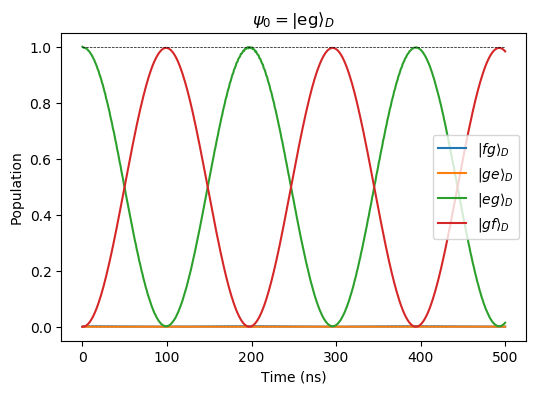

In [14]:
prob_fg = np.array([np.abs(levels['fg'].overlap(result[t]))**2 for t in range(len(times))])
prob_ge = np.array([np.abs(levels['ge'].overlap(result[t]))**2 for t in range(len(times))])
prob_eg = np.array([np.abs(levels['eg'].overlap(result[t]))**2 for t in range(len(times))])
prob_gf = np.array([np.abs(levels['gf'].overlap(result[t]))**2 for t in range(len(times))])
# prob_ee = np.array([np.abs(levels['ee'].overlap(result[t]))**2 for t in range(len(times))])
# prob_gg = np.array([np.abs(levels['gg'].overlap(result[t]))**2 for t in range(len(times))])

plt.plot(times, prob_fg, label=r'$|fg\rangle_D$')
plt.plot(times, prob_ge, label=r'$|ge\rangle_D$')
plt.plot(times, prob_eg, label=r'$|eg\rangle_D$')
plt.plot(times, prob_gf, label=r'$|gf\rangle_D$')
# plt.plot(times, prob_ee, label=r'$|ee\rangle_D$')
# plt.plot(times, prob_gg, label=r'$|gg\rangle$')
plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle_D$')
plt.show()

In [15]:
# Get pi pulse length (could do a fit but this is easier)
popln = np.array([np.abs(levels[psi0_name].overlap(result[t]))**2 for t in range(len(times))])
search_ti = 0
search_tf = 300 
pi = np.argmin(np.abs(times-search_ti)) + \
    np.argmin(popln[np.argmin(np.abs(times-search_ti)):np.argmin(np.abs(times-search_tf))])
print(times[pi])

295.59118236472943
